In [1]:
'''
python T2_IcubCNN_ae.py -k 0 -c 0 -r 1 -rr 3
'''
# Import

import os,sys
CURRENT_TEST_DIR = os.getcwd()
sys.path.append(CURRENT_TEST_DIR + "/../new_iteration/")
import pickle
import argparse
from sklearn.metrics import confusion_matrix
from datetime import datetime

from vrae.vrae import VRAEC
from vrae.utils import *
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
from torch.utils import data as data2
from torch.utils.data.dataset import random_split
from torch.utils.data import DataLoader, TensorDataset
from datetime import datetime
from tas_utils_bs import get_trainValLoader, get_testLoader
import plotly


In [2]:
# Parse argument
parser = argparse.ArgumentParser()
parser.add_argument("-k", "--kfold", type=int, default=0, help="kfold_number for loading data")
parser.add_argument("-r", "--reduction", type=int, default=1, help="data reduction ratio for partial training")
parser.add_argument("-c", "--cuda", default=0, help="index of cuda gpu to use")
parser.add_argument("-rr", "--removal", type=int, default=0, help="number of batches removed from training")
args = parser.parse_args()

In [3]:
# # dummy class to replace argparser
# class Args:
#   kfold = 0
#   reduction = 1
#   cuda = '1'
#   removal = 2

# args=Args()

In [4]:
if args.reduction != 1:
    print("load {} kfold number, reduce data to {} folds, put to cuda:{}".format(args.kfold, args.reduction, args.cuda))
    assert args.removal == 0, "removal must be 0 for kfold reduction"
elif args.removal != 0:
    print("load {} kfold number, remove {} batch of training data, put to cuda:{}".format(args.kfold, args.removal, args.cuda))
else:
    print("load {} kfold number, put to cuda:{}, train with full data".format(args.kfold, args.cuda))

# Set hyper params
kfold_number = args.kfold
data_reduction_ratio = args.reduction
removal = args.removal
shuffle = False
num_class = 20
sequence_length = 75
number_of_features = 60

hidden_size = 90
hidden_layer_depth = 1
latent_length = 40
batch_size = 32
learning_rate = 0.0005
n_epochs = 2000
dropout_rate = 0.2
cuda = True # options: True, False
print_every=30
clip = True # options: True, False
max_grad_norm=5
header = "CNN"
w_r = 0.01
w_c = 1
np.random.seed(1)
torch.manual_seed(1)

load 0 kfold number, remove 2 batch of training data, put to cuda:1


In [5]:
# Load data
data_dir = '../../new_data_folder/'

logDir = 'models_and_stat/'
model_name = 'IcubCNN_ae_{}_rm_{}_wrI_{}_wC_{}_{}'.format(data_reduction_ratio, removal, w_r, w_c, str(kfold_number))
device = torch.device("cuda:{}".format(args.cuda))
print("Loading data...")
train_loader, val_loader, train_dataset, val_dataset = get_trainValLoader(data_dir, k=kfold_number, spike_ready=False, batch_size=batch_size, shuffle=shuffle)
test_loader, test_dataset = get_testLoader(data_dir, spike_ready=False, batch_size=batch_size, shuffle=shuffle)

Loading data...


In [6]:
# Create model
model = VRAEC(num_class=num_class,
            sequence_length=sequence_length,
            number_of_features = number_of_features,
            hidden_size = hidden_size, 
            hidden_layer_depth = hidden_layer_depth,
            latent_length = latent_length,
            batch_size = batch_size,
            learning_rate = learning_rate,
            n_epochs = n_epochs,
            dropout_rate = dropout_rate,
            cuda = cuda,
            print_every=print_every, 
            clip=clip, 
            max_grad_norm=max_grad_norm,
            dload = logDir,
            model_name=model_name,
            header=header,
            device = device)

model.to(device)

/home/students/student6_16/anaconda3/lib/python3.7/site-packages/torch/nn/modules/rnn.py:51: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



VRAE(n_epochs=5,batch_size=32,cuda=True)

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
cl_loss_fn = nn.NLLLoss()
recon_loss_fn = nn.MSELoss()

In [8]:
# 1st stage training: with recon_loss
training_start=datetime.now()
#split fit
epoch_train_loss = []
epoch_train_acc = []
epoch_val_loss = []
epoch_val_acc = []
max_val_acc = 0

for epoch in range(n_epochs):
    
    # TRAIN
    model.train()
    correct = 0
    train_loss = 0
    train_num = 0
    for i, (XI, XB,  y) in enumerate(train_loader):
        
        if i >= len(train_loader)-removal:
            break
        
        if model.header == 'CNN':
            x = XI
        else:
            x = XB
        x, y = x.to(device), y.long().to(device)
        if x.size()[0] != batch_size:
#             print("batch {} size {} < {}, skip".format(i, x.size()[0], batch_size))
            break
    
        if i % data_reduction_ratio == 0:
            train_num += x.size(0)
            optimizer.zero_grad()

            x_decoded, latent, output = model(x)

            # construct loss function
            cl_loss = cl_loss_fn(output, y)
            recon_loss = recon_loss_fn(x_decoded, x)
            loss = w_c*cl_loss + w_r *recon_loss
            loss.backward()
            optimizer.step()
            # compute classification acc
            pred = output.data.max(1, keepdim=True)[1]  # get the index of the max log-probability
            correct += pred.eq(y.data.view_as(pred)).long().cpu().sum().item()

            # accumulator
            train_loss += loss.item()

    # fill stats
    if epoch < 20 or epoch%200 == 0:
        print("train last batch: recon_loss {:.3f}".format(loss))
    train_accuracy = correct / train_num
    train_loss /= train_num
    epoch_train_loss.append(train_loss)
    epoch_train_acc.append(train_accuracy) 
    
    # VALIDATION
    model.eval()
    correct = 0
    val_loss = 0
    val_num = 0
    for i, (XI, XB,  y) in enumerate(val_loader):
        if model.header == 'CNN':
            x = XI
        else:
            x = XB
        x, y = x.to(device), y.long().to(device)
        if x.size()[0] != batch_size:
#             print("batch {} size {} < {}, skip".format(i, x.size()[0], batch_size))
            break
        val_num += x.size(0)
        x_decoded, latent, output = model(x)

        # construct loss function
        cl_loss = cl_loss_fn(output, y)
        recon_loss = recon_loss_fn(x_decoded, x)
        loss = w_c*cl_loss + w_r *recon_loss
    
        # compute classification acc
        pred = output.data.max(1, keepdim=True)[1]  # get the index of the max log-probability
        correct += pred.eq(y.data.view_as(pred)).long().cpu().sum().item()
        
        # accumulator
        val_loss += loss.item()

    # fill stats
    val_accuracy = correct / val_num# / len(val_loader.dataset)
    val_loss /= val_num #len(val_loader.dataset)

    epoch_val_loss.append(val_loss)  # only save the last batch
    epoch_val_acc.append(val_accuracy)
    if epoch < 20 or epoch%200 == 0:
        print('Epoch: {} Loss: train {:.3f}, valid {:.3f}. Accuracy: train: {:.3f}, valid {:.3f}'.format(epoch, train_loss, val_loss, train_accuracy, val_accuracy))
    
    # choose model
    if max_val_acc <= val_accuracy:
        model_dir = logDir + model_name + '.pt'
        print('Saving model at {} epoch to{}'.format(epoch, model_dir))
        max_val_acc = val_accuracy
        torch.save(model.state_dict(), model_dir)

training_end =  datetime.now()
training_time = training_end -training_start 
print("training takes time {}".format(training_time))

train last batch: recon_loss 5.146
Epoch: 0 Loss: train 0.165, valid 0.162. Accuracy: train: 0.074, valid 0.083
Saving model at 0 epoch tomodels_and_stat/IcubCNN_ae_1_rm_2_wrI_0.01_wC_1_0.pt
train last batch: recon_loss 5.034
Epoch: 1 Loss: train 0.161, valid 0.159. Accuracy: train: 0.178, valid 0.214
Saving model at 1 epoch tomodels_and_stat/IcubCNN_ae_1_rm_2_wrI_0.01_wC_1_0.pt
train last batch: recon_loss 4.843
Epoch: 2 Loss: train 0.156, valid 0.153. Accuracy: train: 0.318, valid 0.349
Saving model at 2 epoch tomodels_and_stat/IcubCNN_ae_1_rm_2_wrI_0.01_wC_1_0.pt
train last batch: recon_loss 4.497
Epoch: 3 Loss: train 0.148, valid 0.144. Accuracy: train: 0.441, valid 0.458
Saving model at 3 epoch tomodels_and_stat/IcubCNN_ae_1_rm_2_wrI_0.01_wC_1_0.pt
train last batch: recon_loss 4.071
Epoch: 4 Loss: train 0.137, valid 0.132. Accuracy: train: 0.513, valid 0.510
Saving model at 4 epoch tomodels_and_stat/IcubCNN_ae_1_rm_2_wrI_0.01_wC_1_0.pt
training takes time 0:00:06.351713


In [9]:
model.is_fitted = True
model.eval()

VRAE(n_epochs=5,batch_size=32,cuda=True)

In [10]:
# testing set check
net_trained = VRAEC(num_class=num_class,
            sequence_length=sequence_length,
            number_of_features = number_of_features,
            hidden_size = hidden_size, 
            hidden_layer_depth = hidden_layer_depth,
            latent_length = latent_length,
            batch_size = batch_size,
            learning_rate = learning_rate,
            n_epochs = n_epochs,
            dropout_rate = dropout_rate,
            cuda = cuda,
            print_every=print_every, 
            clip=clip, 
            max_grad_norm=max_grad_norm,
            dload = logDir,
            model_name=model_name,
            header=header,
            device = device)

net_trained.load_state_dict(torch.load(logDir + model_name + '.pt'))
net_trained.eval()

VRAE(n_epochs=5,batch_size=32,cuda=True)

In [11]:
correct = 0
test_num = 0
for i, (XI, XB,  y) in enumerate(test_loader):
    if model.header == 'CNN':
        x = XI
    else:
        x = XB
    x, y = x.to(device), y.long().to(device)
    
    if x.size(0) != batch_size:
        print(" test batch {} size {} < {}, skip".format(i, x.size()[0], batch_size))
        break
    test_num += x.size(0)
    x_decoded, latent, output = model(x)

    # compute classification acc
    pred = output.data.max(1, keepdim=True)[1]  # get the index of the max log-probability
    correct += pred.eq(y.data.view_as(pred)).long().cpu().sum().item()
    
test_acc = correct / test_num #len(test_loader.dataset)

print('Test accuracy for', str(kfold_number), ' fold : ', test_acc)

 test batch 6 size 8 < 32, skip
Test accuracy for 0  fold :  0.3854166666666667


In [12]:
# save stats
all_stats = {"epoch_train_loss": epoch_train_loss,
             "epoch_train_acc": epoch_train_acc,
             "epoch_val_loss": epoch_val_loss,
             "epoch_val_acc": epoch_val_acc,
             "test_acc": test_acc}

dict_name = logDir + model_name + '_stats.pkl'
pickle.dump(all_stats, open(dict_name, 'wb'))


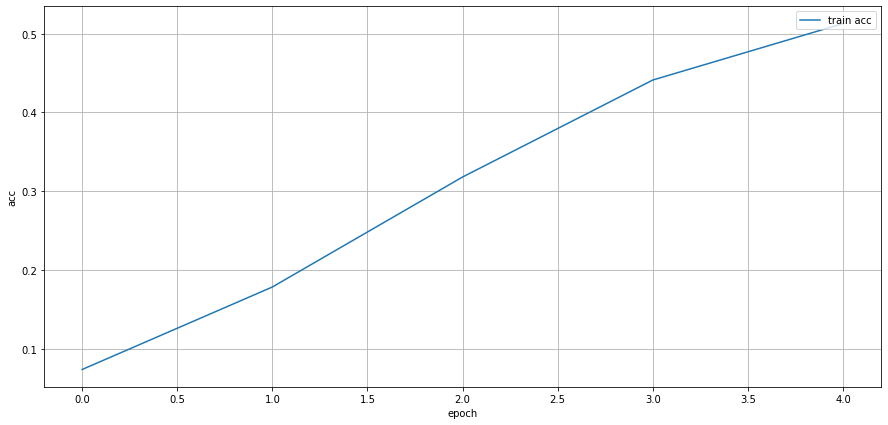

In [13]:
assert n_epochs == len(epoch_train_acc), "different epoch length {} {}".format(n_epochs, len(epoch_train_acc))
fig, ax = plt.subplots(figsize=(15, 7))
ax.plot(np.arange(n_epochs), epoch_train_acc, label="train acc")
ax.set_xlabel('epoch')
ax.set_ylabel('acc')
ax.grid(True)
plt.legend(loc='upper right')
figname = logDir + model_name +"_train1_acc.png"
plt.savefig(figname)
plt.show()


In [14]:
# 